# Tree of hydrolase 2090

- Homology search is documented in [`notebook/hydrolase_tree.ipynb`](notebook/hydrolase_tree.ipynb).
- Alignment, trimming and tree building is done in script: [`src/tree/make_tree.sh`](src/tree/make_tree.sh).

In [4]:
import os
from pathlib import Path
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from Bio import Phylo

cwd = os.getcwd()
if cwd.endswith('notebook'):
    os.chdir('..')
    cwd = os.getcwd()

from src.tree.itol_annotation import itol_labels, itol_color_strip_annotations, itol_protein_domain_annotations

In [5]:
sns.set_palette('colorblind')
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.8)
plt.rcParams['font.family'] = 'Helvetica'

palette = sns.color_palette().as_hex()
palette_20 = [
    '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
    '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
    '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', 
    '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080',
]  # Source: https://sashamaps.net/docs/resources/20-colors/

data_folder = Path('./data')
assert data_folder.is_dir()

## Alignment

### Deleted sequences

After proteins have been aligned, and the alignment trimmed, sequences with more than 50% gaps are removed.

How many sequences were dropped? Which ones?

In [6]:
trimmed_aln = SeqIO.to_dict(SeqIO.parse(data_folder / 'hydrolase_tree' / 'sequences.aln.trimmed.fasta', 'fasta'))
final_aln = SeqIO.to_dict(SeqIO.parse(data_folder / 'hydrolase_tree' / 'alignment_final.fasta', 'fasta'))

dropped_ids = sorted(set(trimmed_aln.keys()) - set(final_aln.keys()))

print('Number of sequences dropped:', len(dropped_ids))

Number of sequences dropped: 6


In [7]:
metadata_df = pd.read_csv(data_folder / 'hydrolase_search' / 'search_output.csv', index_col='id')
dropped_records = metadata_df.loc[dropped_ids]
dropped_records

,gtdb_id,db_proka_id,uniprot_id,domain,gtdb_phylum,gtdb_class,gtdb_order,gtdb_family,gtdb_genus,gtdb_species,ncbi_phylum,ncbi_class,ncbi_order,ncbi_family,ncbi_genus,ncbi_species,tstart,tend,evalue,bits
id,,,,,,,,,,,,,,,,,,,,
A0A5Q0UT33,NZ_CP044130.1_50,NaN,A0A5Q0UT33,Archaea,Halobacteriota,Halobacteria,Halobacteriales,Haloarculaceae,Halomicrobium,Halomicrobium sp009617995,Euryarchaeota,Halobacteria,Halobacteriales,Haloarculaceae,Halomicrobium,Halomicrobium sp. LC1Hm,35,137,5.661000e-05,57
A0A6A7LEE0,NaN,NaN,A0A6A7LEE0,Archaea,NaN,NaN,NaN,NaN,NaN,NaN,Nitrososphaerota,Nitrososphaeria,Nitrososphaerales,Nitrososphaeraceae,NaN,Nitrososphaeraceae archaeon,10,87,7.392000e-09,69
A0A835X6S7,NaN,NaN,A0A835X6S7,Archaea,NaN,NaN,NaN,NaN,NaN,NaN,Nitrososphaerota,Nitrososphaeria,Nitrosopumilales,NaN,NaN,Nitrosopumilales archaeon,43,147,4.548000e-06,61
A0A842N6W6,NaN,NaN,A0A842N6W6,Archaea,NaN,NaN,NaN,NaN,NaN,NaN,Nitrososphaerota,NaN,NaN,NaN,Candidatus Nitrosopelagicus,Candidatus Nitrosopelagicus sp.,7,142,1.903000e-06,62
JAHENP010000151.1_1,JAHENP010000151.1_1,NaN,NaN,Archaea,Halobacteriota,Halobacteria,Halobacteriales,Haloferacaceae,Halobaculum,Halobaculum sp018609965,NaN,NaN,NaN,NaN,NaN,NaN,16,137,5.670000e-04,54
WP_210424182.1@GCF_004765785.1,NZ_SBIT01000010.1_266,WP_210424182.1@GCF_004765785.1,NaN,Archaea,Halobacteriota,Halobacteria,Halobacteriales,Haladaptataceae,Halorussus,Halorussus ruber,NaN,NaN,NaN,NaN,NaN,NaN,17,93,6.847000e-19,100


6 of 6 are archaea.

In [8]:
pfam_df = pd.read_csv(data_folder / 'hydrolase_search' / 'search_output.pfam.csv', index_col='protein_id')
pfam_df.loc[sorted(set(pfam_df.index) & set(dropped_ids))]

,hmm_accession,hmm_query,evalue,bitscore,accuracy,start,end
protein_id,,,,,,,
A0A835X6S7,PF05990.17,DUF900,1.200000e-07,26.3,0.79,31,148


5 of 6 do not have a single Pfam entry.

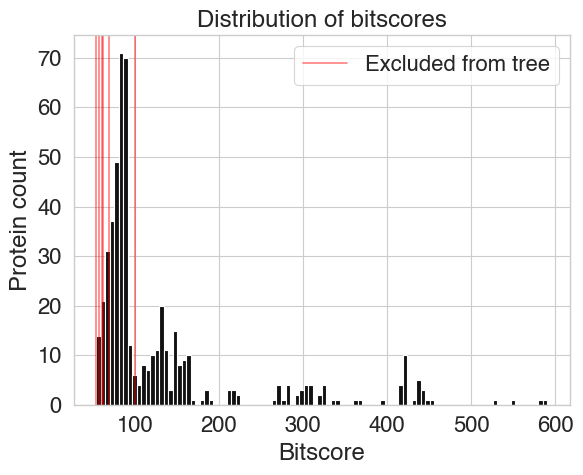

In [9]:
ax = metadata_df['bits'].hist(bins=100, color='#111111');

for i, bitscore in enumerate(dropped_records['bits'].values):
    label = 'Excluded from tree' if i == 0 else None
    ax.axvline(bitscore, color='red', alpha=0.5, label=label)

ax.set_title('Distribution of bitscores');
ax.set_xlabel('Bitscore');
ax.set_ylabel('Protein count');
ax.legend();

All 6 excluded proteins have low homology score.

## Tree post-processing

IQ-TREE removes all characters deemed "special characters" from a sequence ID and replace them with underscores. 

Let's recover the original IDs.

In [10]:
tree = Phylo.read(data_folder / 'hydrolase_tree' / 'hydrolase_2090.treefile', 'newick')

leaf_ids = set()
for leaf in tree.get_terminals():
    if re.match(r'^.+_GC[AF]_.+$', leaf.name) is not None:
        leaf.name = leaf.name.replace('_GC', '@GC')

    leaf_ids.add(leaf.name)

assert len(set(final_aln.keys()) & leaf_ids) == len(leaf_ids)

final_tree_path = data_folder / 'hydrolase_tree' / 'hydrolase_2090.phyloxml'
with final_tree_path.open('w') as f_out:
    Phylo.write([tree], f_out, 'phyloxml')

tree = Phylo.read(final_tree_path, 'phyloxml')

print(f'Number of leaves: {len(list(tree.get_terminals())):,}')

Number of leaves: 499


## Tree annotations

Tree annotations in [iTOL format](https://itol.embl.de/help.cgi#datasets).

- Labels: species name & protein ID.
- Branch color: orange for archaea and blue for bacteria.
- Color strip: phylum.
- Protein domains: Pfam annotations.

In [11]:
annotations_folder = data_folder / 'hydrolase_tree' / 'itol_annotations'
assert annotations_folder.is_dir()

### Labels: species name & protein ID

In [12]:
labels = []
protein_ids = sorted(leaf_ids)
for protein_id in leaf_ids:
    if protein_id == 'pgaptmp_002090_1':
        label = f'Haloferax sp. S5a-1 (pgaptmp_002090_1)'
        labels.append([protein_id, label])
        continue

    row = metadata_df.loc[protein_id]
    
    if not pd.isnull(row['uniprot_id']):
        species = row['ncbi_species']
        if pd.isnull(species):
            raise ValueError(f'No species specified for protein {protein_id}')
        
        uniprot_id = row['uniprot_id']
        id_str = f'UniProt: {uniprot_id}'
    else:
        species = row['gtdb_species']
        gtdb_id = row['gtdb_id']
        id_str = f'GTDB: {gtdb_id}'
    
    label = f'{species} ({id_str})'

    labels.append([protein_id, label])

itol_labels(
    labels, 
    annotations_folder / 'labels.txt'
)

### Domain: branch colors and colorstrip

In [13]:
domain_labels = []
for protein_id in protein_ids:
    if protein_id == 'pgaptmp_002090_1':
        domain = 'Archaea'
    else:
        domain = metadata_df.loc[protein_id, 'domain']

    if domain == 'Bacteria':
        color = palette[0]     # blue
    elif domain == 'Archaea':
        color = palette[1]     # orange

    domain_labels.append([
        protein_id, 
        color,
        domain,
    ])


itol_color_strip_annotations(
    data=domain_labels,
    output_path=annotations_folder / 'domains.txt',
    dataset_label='Domain',
    legend_title='Domain',
    color_branches=True,
)

### Phylum: colorstrip

Mapping from NCBI to GTDB taxonomy is taken directly from GTDB.

In [14]:
archaea_ncbi_phylum_to_gtdb_phylum = {
    'Nitrososphaerota' : 'Thermoproteota',
}
archaea_ncbi_class_to_gtdb_phylum = {
    'Halobacteria': 'Halobacteriota',
    'Nitrososphaeria': 'Thermoproteota',
}
bacteria_ncbi_phylum_to_gtdb_phylum = {
    'Acidobacteriota': 'Acidobacteriota',
    'Verrucomicrobiota': 'Verrucomicrobiota',
    'Balneolota': 'Bacteroidota',
    'Pseudomonadota': 'Pseudomonadota',
    'Gemmatimonadota': 'Gemmatimonadota',
    'Chlamydiota': 'Chlamydiota',
}

In [15]:
phylum_palette = [
    c for c in palette_20
    if c != '#a9a9a9'
]
unknown_phylum_color = '#a9a9a9'

protein_id_to_phylum = {}
unique_phyla = set()
for protein_id in protein_ids:
    if protein_id == 'pgaptmp_002090_1':
        phylum = 'Halobacteriota'
    else:
        phylum = metadata_df.loc[protein_id, 'gtdb_phylum']
        if pd.isnull(phylum):
            domain = metadata_df.loc[protein_id, 'domain']
            if domain == 'Archaea':
                phylum = archaea_ncbi_class_to_gtdb_phylum.get(
                    metadata_df.loc[protein_id, 'ncbi_class'],
                )
                if pd.isnull(phylum):
                    phylum = archaea_ncbi_phylum_to_gtdb_phylum.get(
                        metadata_df.loc[protein_id, 'ncbi_phylum'],
                        'Unknown',
                    )
            else:
                phylum = bacteria_ncbi_phylum_to_gtdb_phylum.get(
                    metadata_df.loc[protein_id, 'ncbi_phylum'],
                    'Unknown',
                )

    protein_id_to_phylum[protein_id] = phylum

    if phylum != 'Unknown':
        unique_phyla.add(phylum)

unique_phyla = sorted(unique_phyla)

phylum_labels = []
for protein_id in protein_ids:
    phylum = protein_id_to_phylum[protein_id]

    if phylum == 'Unknown':
        color = unknown_phylum_color
    else:
        color = phylum_palette[unique_phyla.index(phylum)]

    phylum_labels.append([protein_id, color, phylum])


itol_color_strip_annotations(
    data=phylum_labels,
    output_path=annotations_folder / 'phyla.txt',
    dataset_label='Phylum',
    legend_title='Phylum (GTDB release 214)',
    color_branches=False,
)

### Pfam protein domains annotations

In [17]:
pfam_df = pd.read_csv(data_folder / 'hydrolase_search' / 'search_output.pfam.csv', index_col='protein_id')
pfam_df.head()

,hmm_accession,hmm_query,evalue,bitscore,accuracy,start,end
protein_id,,,,,,,
A0A075FKQ7,PF05990.17,DUF900,4.900000e-10,34.2,0.80,31,220
A0A075GAR9,PF05990.17,DUF900,3.600000e-08,28.1,0.82,39,210
A0A075GDE7,PF05990.17,DUF900,3.800000e-11,37.8,0.83,37,215
A0A075GE09,PF05990.17,DUF900,3.800000e-08,28.0,0.78,31,206
A0A075GFP7,PF05990.17,DUF900,3.600000e-08,28.1,0.82,39,210


In [19]:
protein_length_map = {
    r.id: len(r)
    for r in SeqIO.parse(data_folder / 'hydrolase_tree' / 'sequences.fasta', 'fasta')
}

In [35]:
all_domains = pfam_df['hmm_query'].value_counts().index.tolist()
len(all_domains)

11

In [50]:
protein_domain_labels = []
palette_pfam_domains = palette[2:] + [c for c in reversed(palette_20) if c not in ('#a9a9a9', '#808080')]
assert len(palette_pfam_domains) >= len(all_domains), (len(palette_pfam_domains), len(all_domains))

for protein_id in protein_ids:
    protein_length = protein_length_map[protein_id]

    if protein_id not in pfam_df.index:
        protein_domain_labels.append([protein_id, protein_length])
        continue

    domains = pfam_df.loc[[protein_id]]

    domains_definition = []
    for tpl in domains.itertuples():
        domain_label = tpl.hmm_query
        domain_color = palette_pfam_domains[all_domains.index(domain_label)]
        domain_def = '|'.join(['RE', str(tpl.start), str(tpl.end), domain_color, domain_label])
        domains_definition.append(domain_def)

    protein_domain_labels.append([protein_id, protein_length] + domains_definition)

itol_protein_domain_annotations(
    protein_domain_labels,
    output_path=annotations_folder / 'protein_domains.txt',
    show_domain_label=False,
    labels_on_top=False,
    dataset_label='Pfam protein domains',
    backbone_color='#dddddd',
    backbone_height=1,
    label_sorter=lambda label: all_domains.index(label)
)